# 3D MRI Brain tumor segmentation || U-NET
# GeneRXN projects
## Licensing and foreword

The present notebook is based on [Mikolaj's example](https://www.kaggle.com/code/mikolajbuchwald/3d-mri-brain-tumor-segmentation-u-net) that utilizes [the BraTS2020 dataset from awsaf's account](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation).

## Problem definiton
**Segmentation of gliomas in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
* Anything else -> pixel is not on a tumor region (0)

The sub-regions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT)
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else.



## Requirements

The contents of a `requirements.txt` file (for offline and/or proprietary server usage):

```
jupyter
keras
matplotlib
nibabel
nifti2gif
nilearn
notebook
numpy
opencv-python
pandas
pydot
scikit-image
seaborn
tensorflow
```

You can also use the file I have put in the "Data" section, under [this link](https://www.kaggle.com/datasets/mikolajbuchwald/requirements?select=requirements.txt).

In order to install the requirements, prior to importing the libraries, either use command line interace with `pip install -r requirements.txt`, or run the cell below. (Note that I ommited `jupyte` and `notebook` modules, because I am assuming that since you have run the notebook, you already have these two libraries installed, only the rest may be missing from you virtual environment.)

**Note!** In order to run the command below in keggle, you have to enable the settings options, see: https://www.kaggle.com/questions-and-answers/36982#1003614

In [ ]:
!pip install keras matplotlib nibabel nifti2gif nilearn numpy opencv-python pandas pydot scikit-image seaborn tensorflow

<img src="https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg" alt="rats official annotations" style="width: 1500px;"/>

# Dataset

## Get the dataset ready in google colab environment. This step requires a kaggle account and according API json file. For further instructions check [Varsha's notebook](https://www.kaggle.com/general/156610).

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # assume the scope of I/O is google drive
# from google.colab import files
# files.upload() #this will prompt you to upload the kaggle.json

Mounted at /content/gdrive


In [ ]:
# make sure kaggle.json file is present
!ls -lha kaggle.json
# Install kaggle API client
!pip install -q kaggle
# kaggle API client expects the file to be in ~/.kaggle so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# we need to set permissions
!chmod 600 /root/.kaggle/kaggle.json
# check your directory before downloading the datasets
!pwd
# list all available datasets
!kaggle datasets list
# download the brats20 dataset
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

In [ ]:
# make sure the datset presents
!ls -lha brats20-dataset-training-validation.zip
# move this to the dataset folder, its for my personal setup only
#!cp brats20-dataset-training-validation.zip "/content/gdrive/My Drive/Colab Notebooks/BrainProjects/data/"
!ls "/content/gdrive/My Drive/Colab Notebooks/BrainProjects/data/"
!unzip "/content/gdrive/My Drive/Colab Notebooks/BrainProjects/data/brats20-dataset-training-validation.zip" -d "/content/gdrive/My Drive/Colab Notebooks/BrainProjects/data/"

# Setup

## Import the libraries and define constants

In [2]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 93.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [3]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
# Specify computational device, 'TPU' or 'GPU'
DEVICE = "GPU" 
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



['name_mapping.csv', 'survival_info.csv', 'BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005', 'BraTS20_Training_006', 'BraTS20_Training_007', 'BraTS20_Training_008', 'BraTS20_Training_009', 'BraTS20_Training_010', 'BraTS20_Training_011', 'BraTS20_Training_012', 'BraTS20_Training_013', 'BraTS20_Training_014', 'BraTS20_Training_015', 'BraTS20_Training_016', 'BraTS20_Training_017', 'BraTS20_Training_018', 'BraTS20_Training_019', 'BraTS20_Training_020', 'BraTS20_Training_021', 'BraTS20_Training_022', 'BraTS20_Training_023', 'BraTS20_Training_024', 'BraTS20_Training_025', 'BraTS20_Training_026', 'BraTS20_Training_027', 'BraTS20_Training_028', 'BraTS20_Training_029', 'BraTS20_Training_030', 'BraTS20_Training_031', 'BraTS20_Training_032', 'BraTS20_Training_033', 'BraTS20_Training_034', 'BraTS20_Training_035', 'BraTS20_Training_036', 'BraTS20_Training_037', 'BraTS20_Training_038', 'BraTS20_Training_039', 'BraTS20_Training_040'

Text(0.5, 1.0, 'Mask')

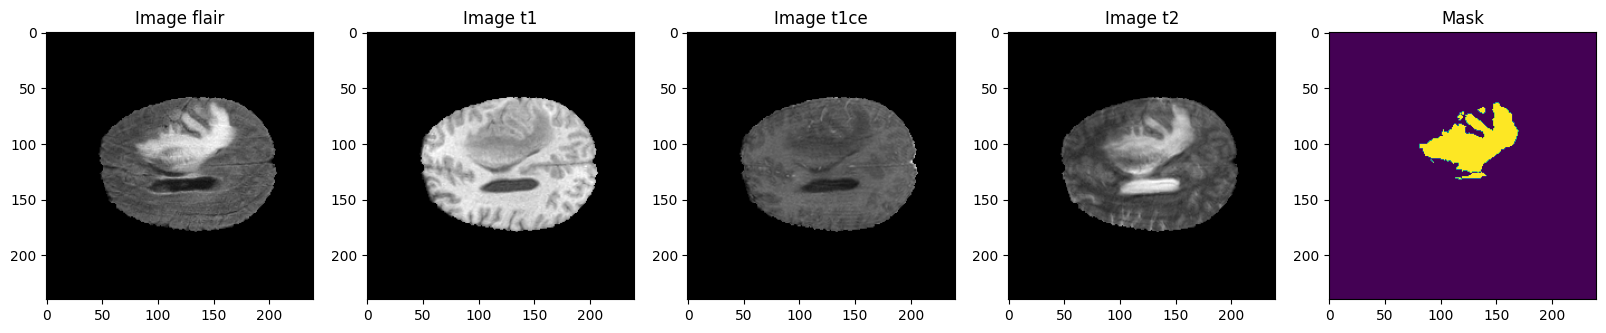

In [5]:
PARENTS_DIR = '/content/gdrive/My Drive/Colab Notebooks/BrainProjects/'
PROJECT_DIR = os.path.join(PARENTS_DIR, 'tumor segmentation')
TRAIN_DATASET_PATH = os.path.join(PARENTS_DIR, "data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/") 
VALIDATION_DATASET_PATH = os.path.join(PARENTS_DIR, "data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/")
print(os.listdir(TRAIN_DATASET_PATH))
print(os.listdir(VALIDATION_DATASET_PATH))


test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show whole nifti data -> print each slice from 3d data**

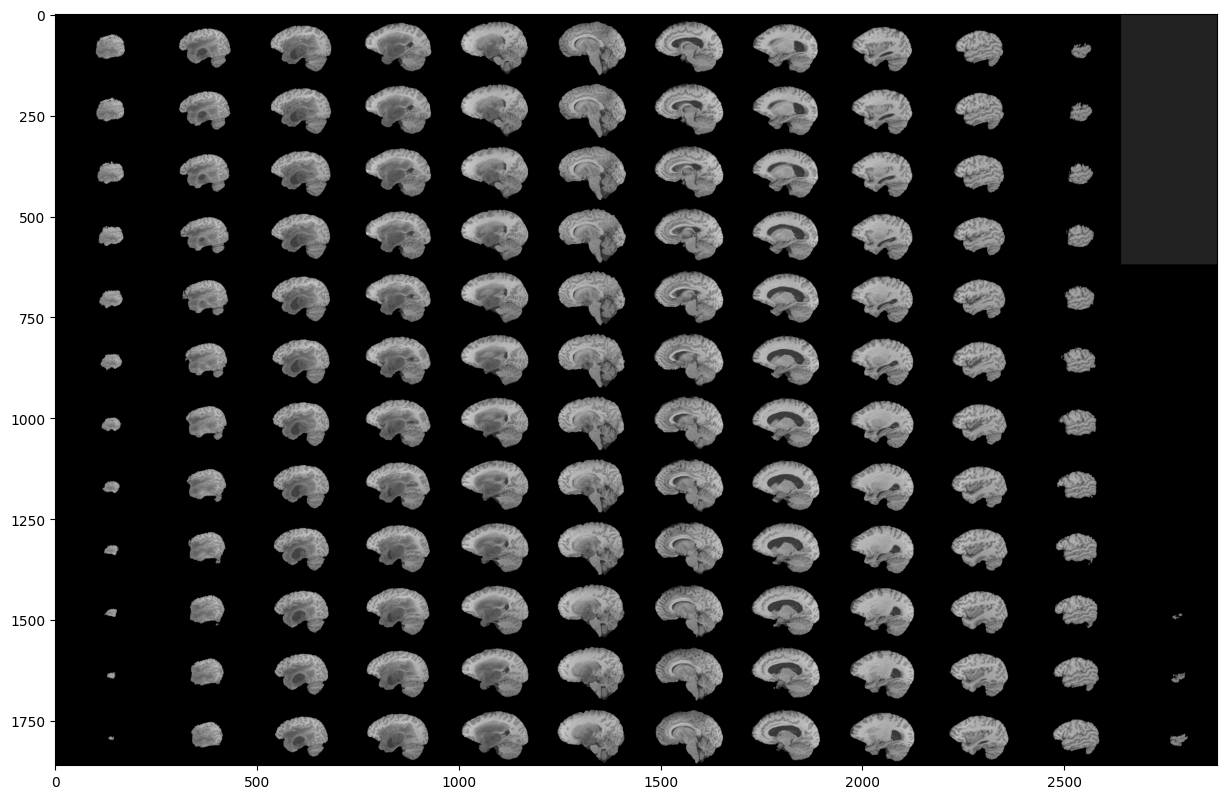

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

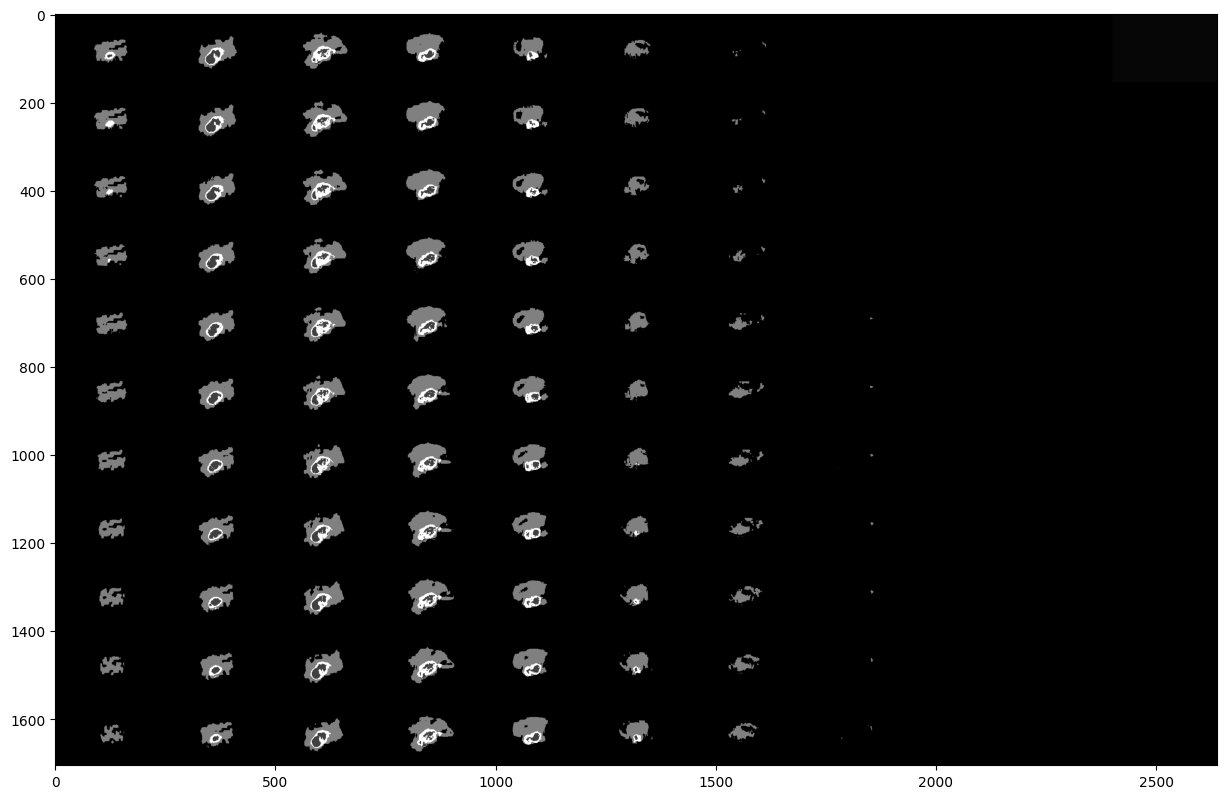

In [30]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

**Show segments of tumor using different effects**

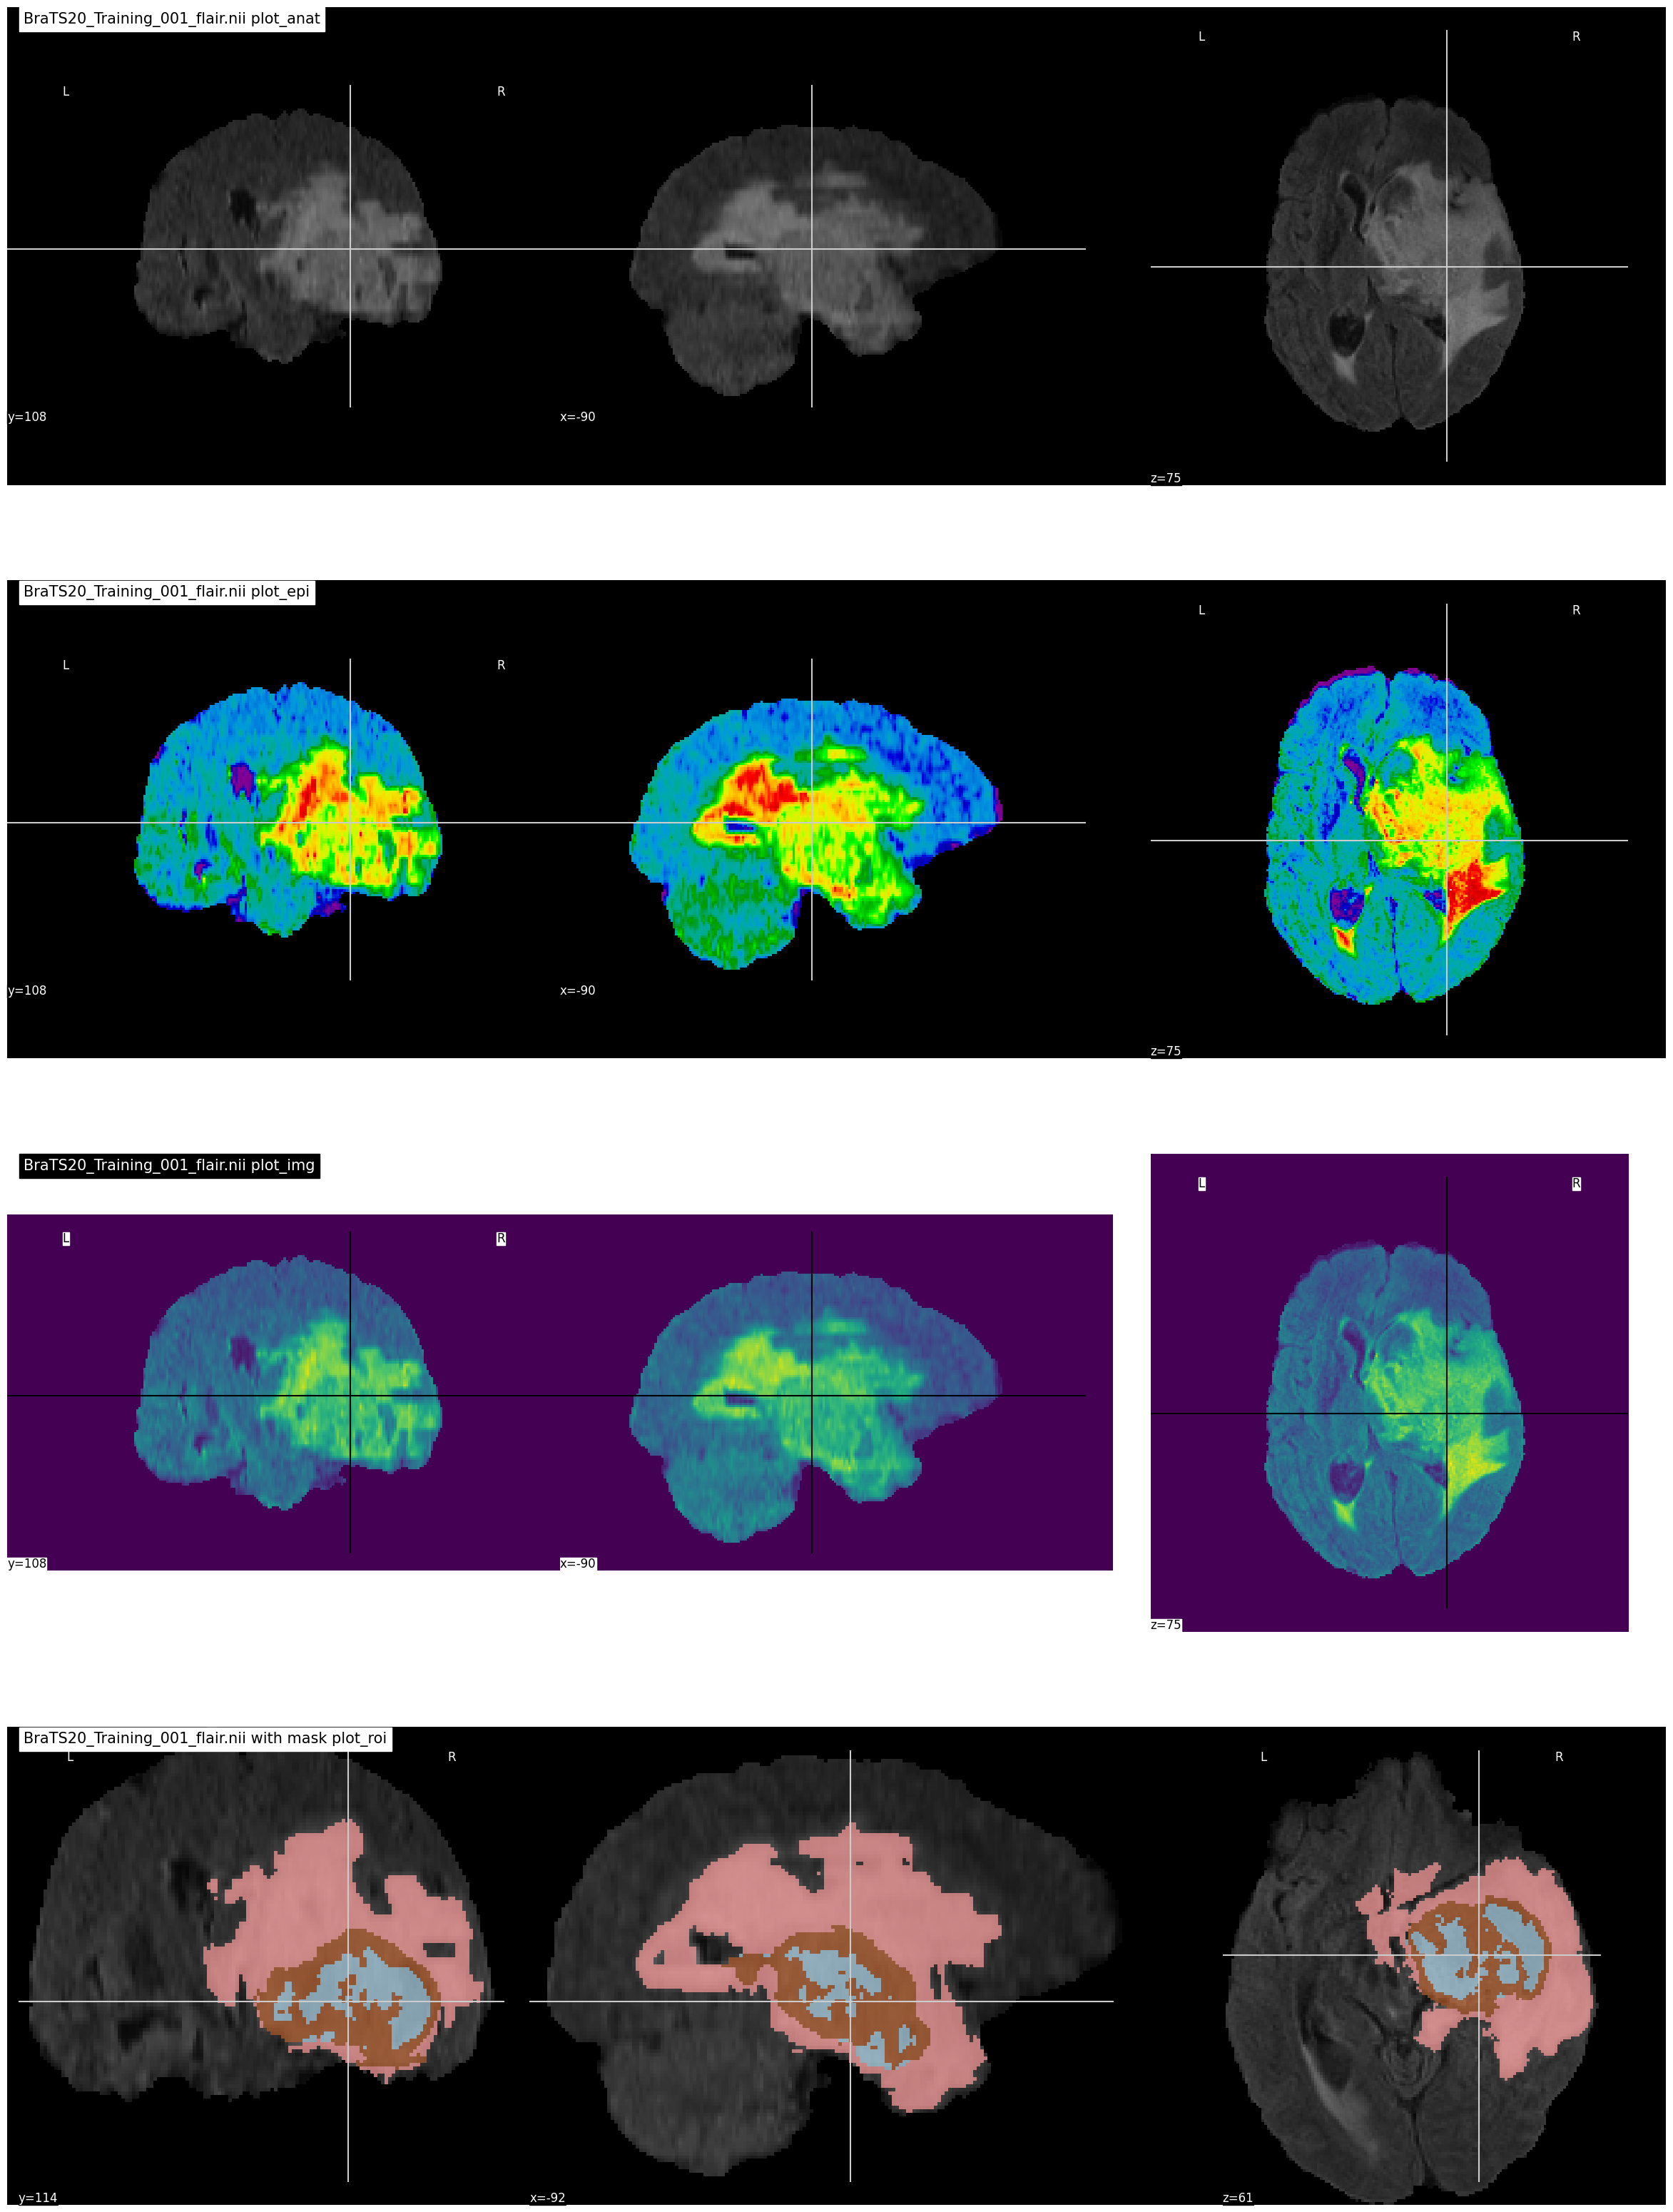

In [32]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

# Create model || U-Net: Convolutional Networks for Biomedical Image Segmentation

U-net is a convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin
[more on](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
![official definiton](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


# Loss function
**Dice coefficient**
, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

![dice loss](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

**As matrices**
![dice loss](https://www.jeremyjordan.me/content/images/2018/05/intersection-1.png)

[Implementation, (images above) and explanation can be found here](https://www.jeremyjordan.me/semantic-segmentation/)

In [66]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def focal_loss(y_true, y_pred):
    alpha = 0.25
    gamma = 2.0
    # Define epsilon so that the backpropagation will not result in NaN
    # for 0 divisor case
    epsilon = K.epsilon()
    # Add the epsilon to prediction value
    #y_pred = y_pred + epsilon
    # Clip the prediction value
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    # Calculate cross entropy
    cross_entropy = -y_true*K.log(y_pred)
    # Calculate weight that consists of  modulating factor and weighting factor
    weight = alpha * y_true * K.pow((1-y_pred), gamma)
    # Calculate focal loss
    loss = weight * cross_entropy
    # Sum the losses in mini_batch
    loss = K.sum(loss)
    return loss
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed    

In [67]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
IMG_SIZE=128
def build_unet(inputs, ker_init, dropout, seed=42):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)
if DEVICE == 'GPU':
    print('Device name: ', tf.config.experimental.list_physical_devices('GPU'))
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
elif DEVICE == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        dice_loss = 1.0 - dice_coef(y_true, y_pred)
        f_l = focal_loss(y_true, y_pred)
        return loss * 0.2 + dice_loss * 0.4 + f_l * 0.4
    
    return loss
weights = np.array([0.01, 2., 1., 3.])
with strategy.scope():
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    model = build_unet(input_layer, 'he_normal', 0.2)
    # model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.003), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

Device name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**model architecture** <br>
If you are about to use U-NET, I suggest to check out this awesome library that I found later, after manual implementation of U-NET [keras-unet-collection](https://pypi.org/project/keras-unet-collection/), which also contains implementation of dice loss, tversky loss and many more!

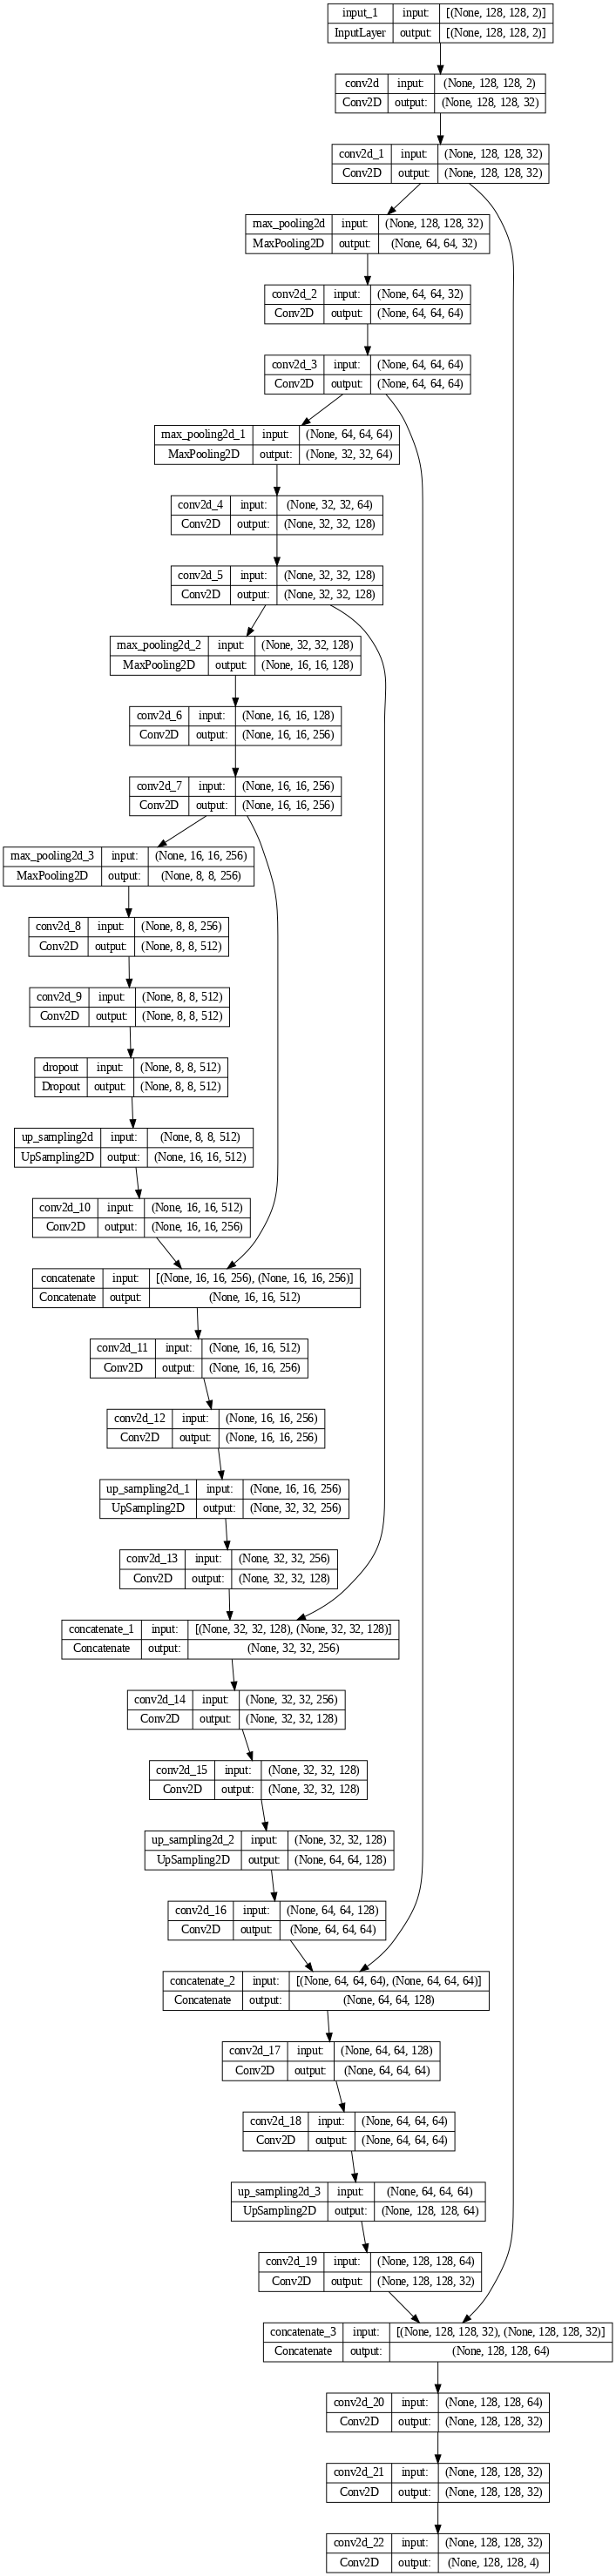

In [8]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [61]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)
print(train_and_test_ids[0:10])
    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005', 'BraTS20_Training_006', 'BraTS20_Training_007', 'BraTS20_Training_008', 'BraTS20_Training_009', 'BraTS20_Training_010']


**Override Keras sequence DataGenerator class**

In [ ]:
possible methods:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers

# Define the paths to your images and masks
image_dir = 'path/to/images'
mask_dir = 'path/to/masks'

# Define the image and mask datasets
image_dataset = image_dataset_from_directory(
    image_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode=None,
    shuffle=True,
    seed=seed
)

mask_dataset = image_dataset_from_directory(
    mask_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode=None,
    shuffle=True,
    seed=seed
)

# Define the augmentation layers
augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1),
])

# Define the preprocessing layers
preprocessing = tf.keras.Sequential([
  Rescaling(1./255),
])

# Combine the augmentation and preprocessing layers
data_augmentation = tf.keras.Sequential([
  augmentation,
  preprocessing
])

# Apply the data augmentation to the image and mask datasets
image_dataset = image_dataset.map(lambda x: data_augmentation(x))
mask_dataset = mask_dataset.map(lambda x: data_augmentation(x))

# Combine the datasets into a single generator
train_dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

# Define your model
model = ...

# Train the model using the generator
model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=num_steps)


In [69]:
class Augment(tf.keras.Model):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs_flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.augment_inputs_rotate = tf.keras.layers.RandomRotation(0.2, seed=seed)
    self.augment_labels_flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.augment_labels_rotate = tf.keras.layers.RandomRotation(0.2, seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs_flip(inputs)
    inputs = self.augment_inputs_rotate(inputs)
    labels = self.augment_labels_flip(labels)
    labels = self.augment_labels_rotate(labels)
    return inputs, labels

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augment = Augment()
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y= self.__data_generation(Batch_ids)

        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Notice that n_sample equal to batch_size * volume_slices
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        X = X / np.max(X)
        [X, Y] = self.augment(inputs=X, labels=Y)
        return X, Y

BATCH_SIZE = 2

training_generator = DataGenerator(train_ids, batch_size=BATCH_SIZE)# real batch size equal to batch size * volume slice
valid_generator = DataGenerator(val_ids, batch_size=BATCH_SIZE)
test_generator = DataGenerator(test_ids, batch_size=BATCH_SIZE)

# cat_area = [0] * 4
# # caculate the difference of numbers of different categories
# for i in range(training_generator.__len__()):
#   X, Y= training_generator.__getitem__(i)
#   Y = tf.math.argmax(Y, axis=3)
#   for cat in range(4):
#     cat_area[cat] += float(tf.math.reduce_sum(tf.cast(Y==cat, tf.int32)).numpy())
# print(float(i) / float(training_generator.__len__()))
# print(cat_area)

In [45]:
pixels_cat = np.array([399498657.0, 1626014.0, 3850296.0, 1348233.0])
percentage = pixels_cat / pixels_cat.sum()
print(percentage)

[0.983 0.004 0.009 0.003]


**Number of data used**
for training / testing / validation

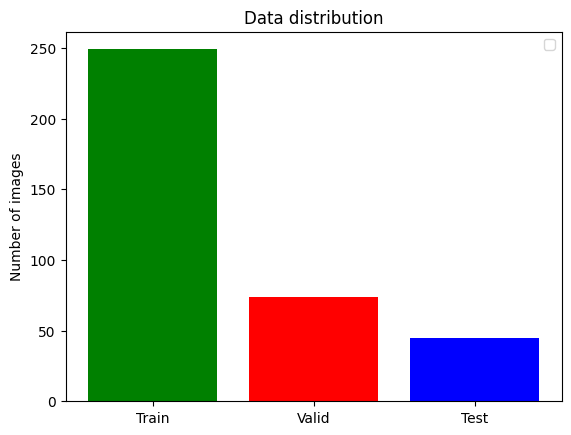

In [70]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

**Add callback for training process**

In [71]:
LOGDIR = os.path.join(PROJECT_DIR, "logs")
if not os.path.exists(LOGDIR):
  os.mkdir(LOGDIR)
LOGPATH = os.path.join(LOGDIR,'training.log')
csv_logger = CSVLogger(LOGPATH, separator=',', append=False)
checkpoint_dir = os.path.join(PROJECT_DIR, "checkpoints")
if not os.path.exists(checkpoint_dir):
  os.mkdir(checkpoint_dir)


callbacks = [
    # keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=8, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=8, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath = os.path.join(checkpoint_dir, 'model_.{epoch:02d}-{val_loss:.6f}.m5'),verbose=1,save_best_only=True, save_weights_only=True),
    csv_logger
    ]

# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again.

In order to load the pre-trained model, download the two files from the https://www.kaggle.com/datasets/rastislav/modelperclasseval repository:

 * `model_per_class.h5`, and
 * `training_per_class.log`;
 
and put them in the `../input/modelperclasseval/` directory.

In [72]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids) // BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data = valid_generator,
                     use_multiprocessing=False,
                     workers=1
                    )
# model.save(os.path.join(checkpoint_dir, "model_x1_1.h5"))

Epoch 1/50
 63/124 [==============>...............] - ETA: 3:23 - loss: 87310.9453 - accuracy: 0.9684 - mean_io_u: 0.9676 - dice_coef: 0.2456 - precision: 0.9663 - sensitivity: 0.9664 - specificity: 0.9940 - dice_coef_necrotic: 5.3258e-04 - dice_coef_edema: 6.4086e-04 - dice_coef_enhancing: 8.5335e-05

KeyboardInterrupt: ignored

**Visualize the training process**

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


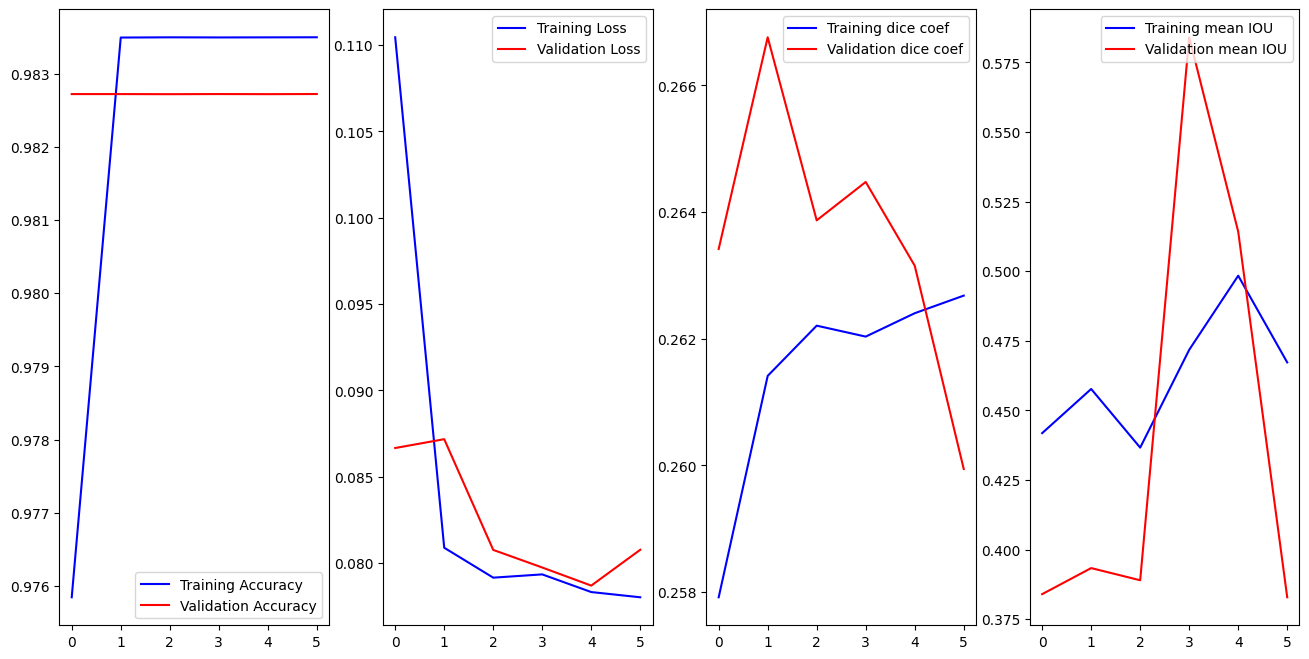

In [15]:
############ load trained model ################
latest = tf.train.latest_checkpoint(checkpoint_dir)
K.clear_session()
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with strategy.scope():
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

model.load_weights(latest)

# model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5', 
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
#                                                    "dice_coef": dice_coef,
#                                                    "precision": precision,
#                                                    "sensitivity":sensitivity,
#                                                    "specificity":specificity,
#                                                    "dice_coef_necrotic": dice_coef_necrotic,
#                                                    "dice_coef_edema": dice_coef_edema,
#                                                    "dice_coef_enhancing": dice_coef_enhancing
#                                                   }, compile=False)

history = pd.read_csv(LOGPATH, sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples 

In [16]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


4/4 [==============================] - 13s 259ms/step


<Figure size 1800x5000 with 0 Axes>

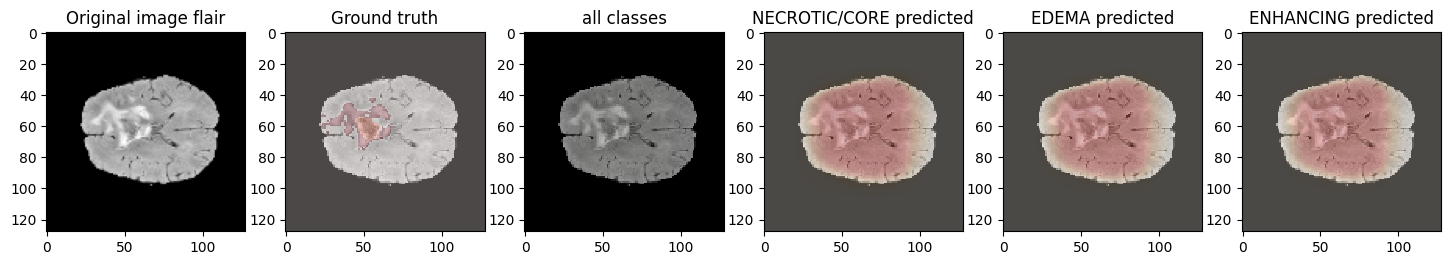

4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

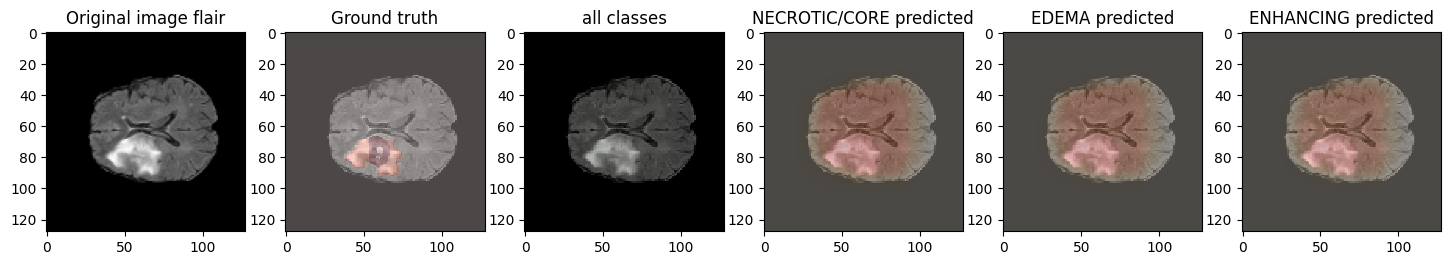

4/4 [==============================] - 0s 73ms/step


<Figure size 1800x5000 with 0 Axes>

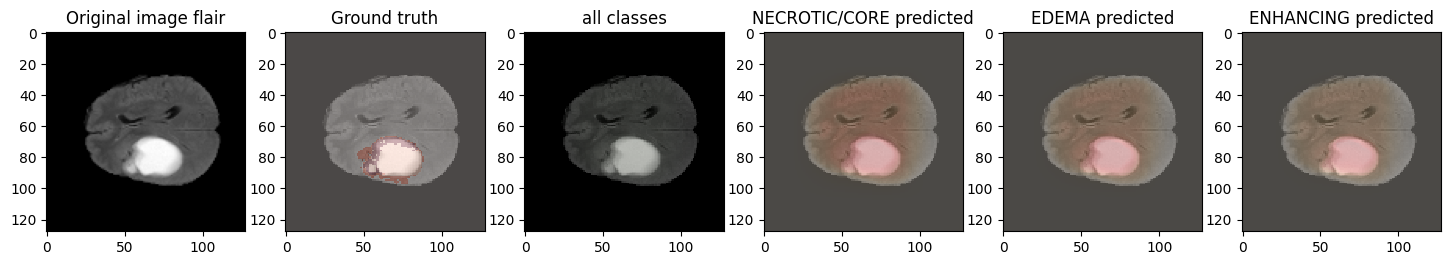

4/4 [==============================] - 0s 71ms/step


<Figure size 1800x5000 with 0 Axes>

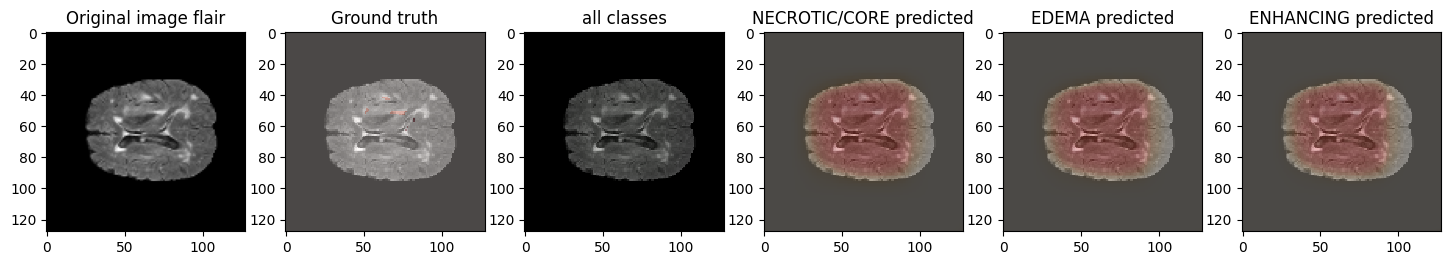

4/4 [==============================] - 0s 66ms/step


<Figure size 1800x5000 with 0 Axes>

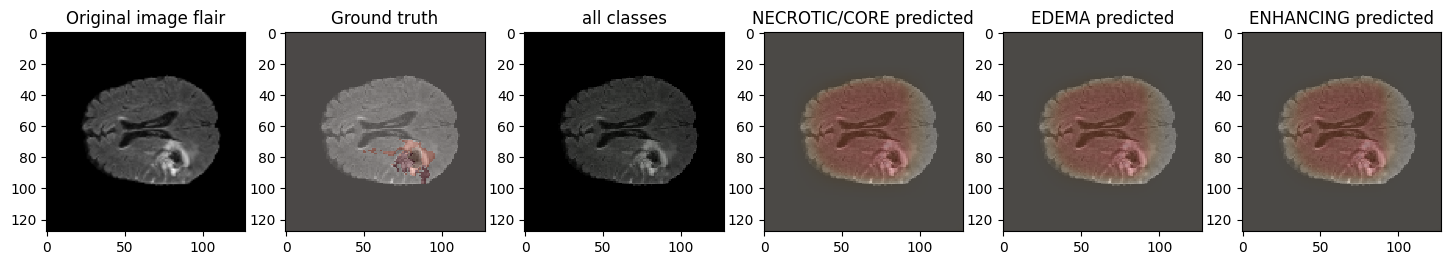

4/4 [==============================] - 0s 70ms/step


<Figure size 1800x5000 with 0 Axes>

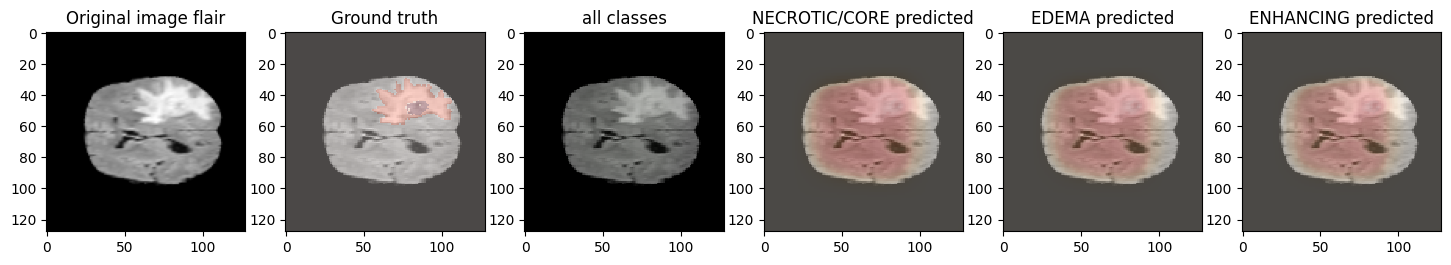

4/4 [==============================] - 0s 72ms/step


<Figure size 1800x5000 with 0 Axes>

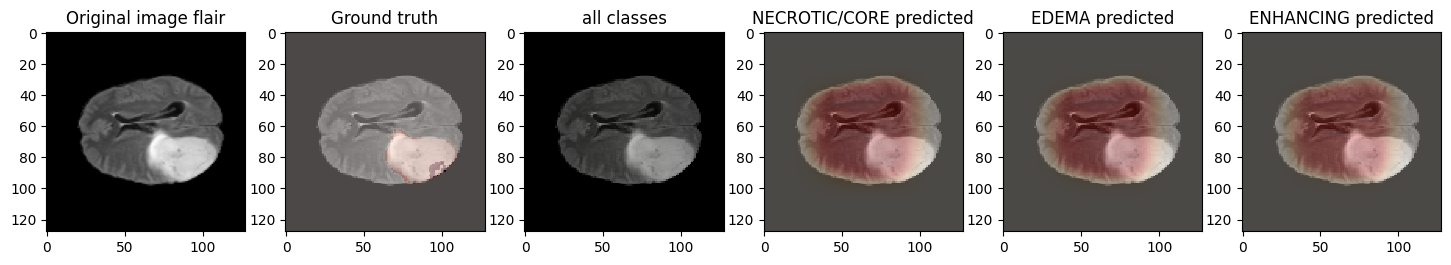

In [17]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    subpath = f"BraTS20_Training_{case}"
    path = os.path.join(TRAIN_DATASET_PATH, subpath)
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

# Evaluation

4/4 [==============================] - 0s 71ms/step


<Figure size 640x480 with 0 Axes>

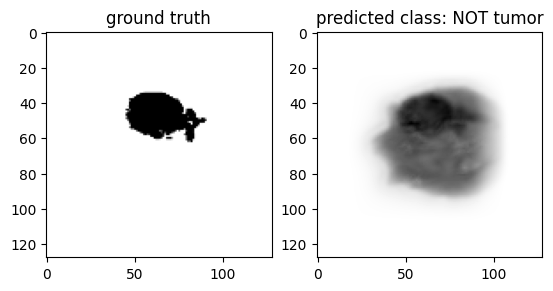

<Figure size 640x480 with 0 Axes>

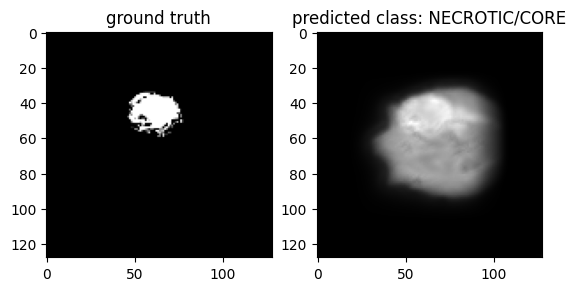

<Figure size 640x480 with 0 Axes>

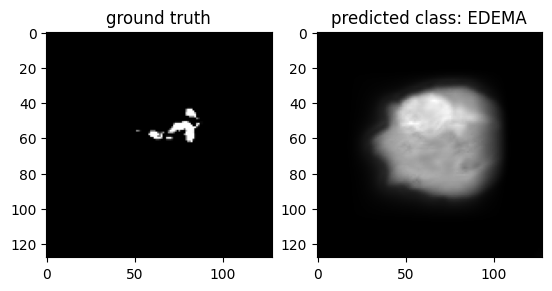

<Figure size 640x480 with 0 Axes>

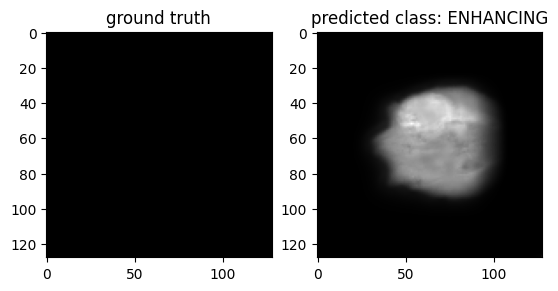

In [18]:
case = case=test_ids[3][-3:]
subpath = f"BraTS20_Training_{case}"
path = os.path.join(TRAIN_DATASET_PATH, subpath)
# path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at



# We need to show an overview of all segmentation classes
#     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'
for eval_class in SEGMENT_CLASSES:
    
    gt_single_class = gt.copy()
    
    gt_single_class[gt_single_class != eval_class] = -1 # use only one class for per class evaluation 

    resized_gt = cv2.resize(gt_single_class[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    plt.figure()
    f, axarr = plt.subplots(1,2) 
    axarr[0].imshow(resized_gt, cmap="gray")
    axarr[0].title.set_text('ground truth')
    axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
    axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
    plt.show()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 397s 9s/step - loss: 0.0157 - accuracy: 0.9945 - mean_io_u_1: 0.8259 - dice_coef: 0.6190 - precision: 0.9948 - sensitivity: 0.9933 - specificity: 0.9982 - dice_coef_necrotic: 0.5702 - dice_coef_edema: 0.7485 - dice_coef_enhancing: 0.6688
test loss, test acc: [0.017068395391106606, 0.9940661787986755, 0.8314087390899658, 0.6345119476318359, 0.9943723082542419, 0.9927531480789185, 0.9980962872505188, 0.5507336854934692, 0.7823114395141602, 0.734682559967041]


# Survival prediction

Full implementation can be found in another [Ratislav's](https://www.kaggle.com/rastislav) notebooks: https://www.kaggle.com/rastislav/mri-brain-tumor-survival-prediction